In [ ]:
# --- Notes ---
# - pg.85: most common supervised learning tasks are regression and classification
# - in this chapter we are using the MNIST dataset, what is this?
# - pg.86: what is the typical dictionary structure for sklearn datasets
# - pg.86: what does matplotlib's imshow() method do?
# - pg.86: what is a feature vector?
# - why does some_digit = X[0] not work?
# - pg.86: how to turn the label from string to integer and why would we do that
# - pg.87: why is shuffling a dataset important
# - pg.88: what is a binary classifier?
# - pg.88: what is stochastic gradient descent (SGD)?
# - pg.88: why is SGD have advantage on large datasets and good for online learning
# - why might you need to turn a data set into an array when testing?
# - pg.88: why might a classifier be more difficult to measure performance than
# a regressor?
# - pg.90: why is accuracy not a preferred performance measure of classifiers?
# - pg.90: what is a confusion matrix
# - pg.90: what is a k-fold
# - pg.91: note the precision equation and what it's used for and how.
# - pg.91: why is 'recall' used with 'precision'
# - pg.91: what is the recall equation and what are its other names?
# - pg.92: confusion matrix explained
# - pg.92: what is called when you combined recall and precision
# - pg.93: why might you want to use a recall or precision over another?
# - pg.93: what trade-offs does precision and recall have?
# - pg.94: understand the graph.
# - pg.94: how do you decide which threshold to use?
# - pg.94: what does 'precision_recall_curve()' function compute
# - pg.95: what does [:-1] mean
# - pg.95: understand the graph on this page fig 3-4
# - pg.97: what is ROC and TNR?
# --- Notes from github ---
# Note: there was an issue in Scikit-Learn 0.19.0 (fixed in 0.19.1) where the result of 
# cross_val_predict() was incorrect in the binary classification case when using 
# method="decision_function", as in the code above. The resulting array had an extra first 
# dimension full of 0s. Just in case you are using 0.19.0, we need to add this small hack to work 
# around this issue.
# ---
# 

In [18]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [19]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [20]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [21]:
mnist.data.shape

(70000, 784)

In [22]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [23]:
y.shape

(70000,)

In [24]:
28*28

784

Saving figure some_digit_plot


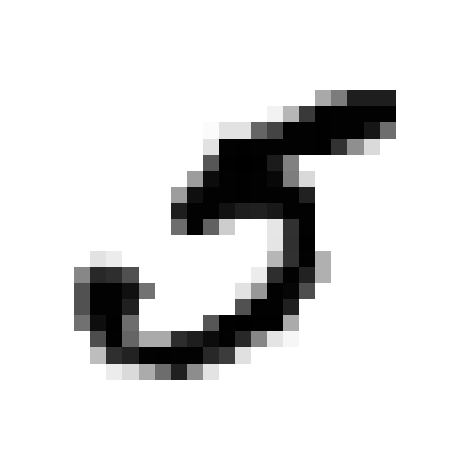

In [25]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [26]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [27]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


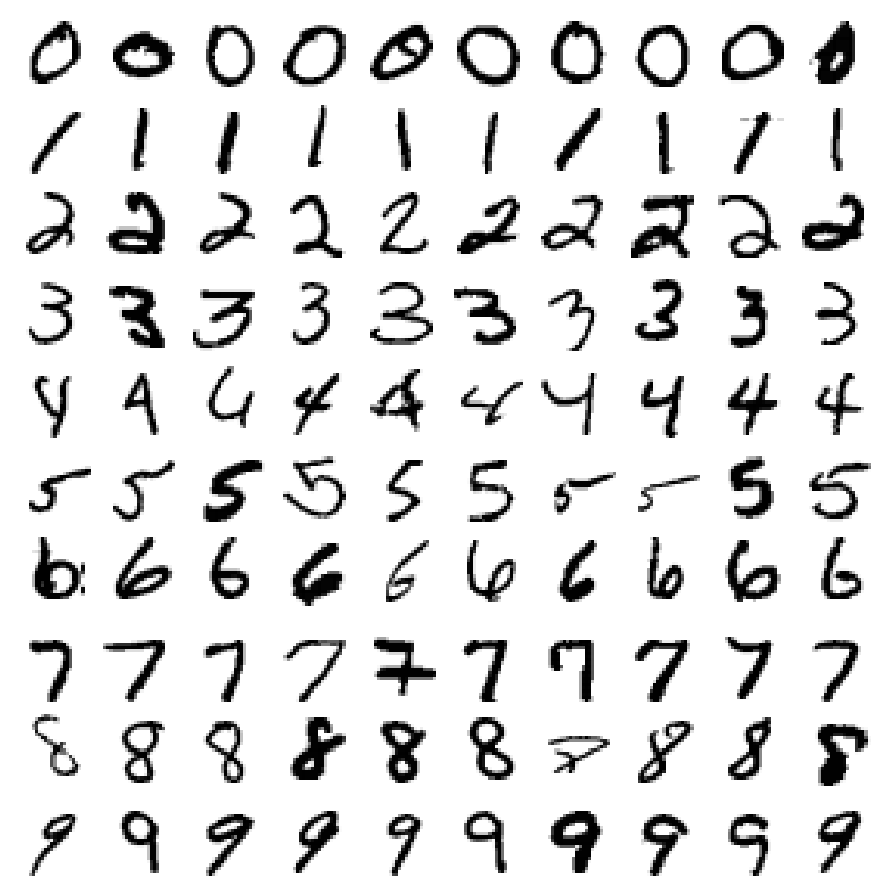

In [28]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [29]:
y[36000]

5

In [30]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [31]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [32]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [34]:
sgd_clf.predict([some_digit])

array([ True])

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9686
0.96205
0.9668


In [37]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [38]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [39]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [40]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]], dtype=int64)

In [41]:
y_train_perfect_predictions = y_train_5

In [43]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [45]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7779476399770686

In [46]:
4344 / (4344 + 1307)

0.7687135020350381

In [47]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

In [48]:
4344 / (4344 + 1077)

0.801328168234643

In [49]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7642200112633752

In [50]:
4344 / (4344 + (1077 + 1307)/2)

0.7846820809248555

In [51]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([150526.40944343])

In [52]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [53]:
y_some_digit_pred

array([ True])

In [54]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [66]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [56]:
y_scores.shape

(60000,)

In [57]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [58]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


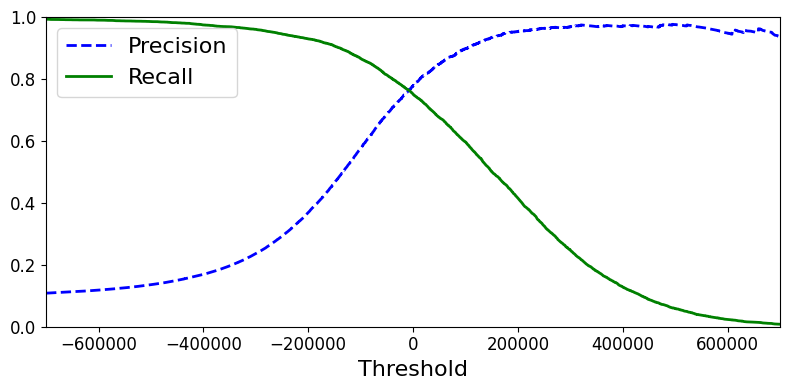

In [59]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [60]:
(y_train_pred == (y_scores > 0)).all()

True

In [61]:
y_train_pred_90 = (y_scores > 70000)

In [62]:
precision_score(y_train_5, y_train_pred_90)

0.8712083540527101

In [63]:
recall_score(y_train_5, y_train_pred_90)

0.6463752075262866

Saving figure precision_vs_recall_plot


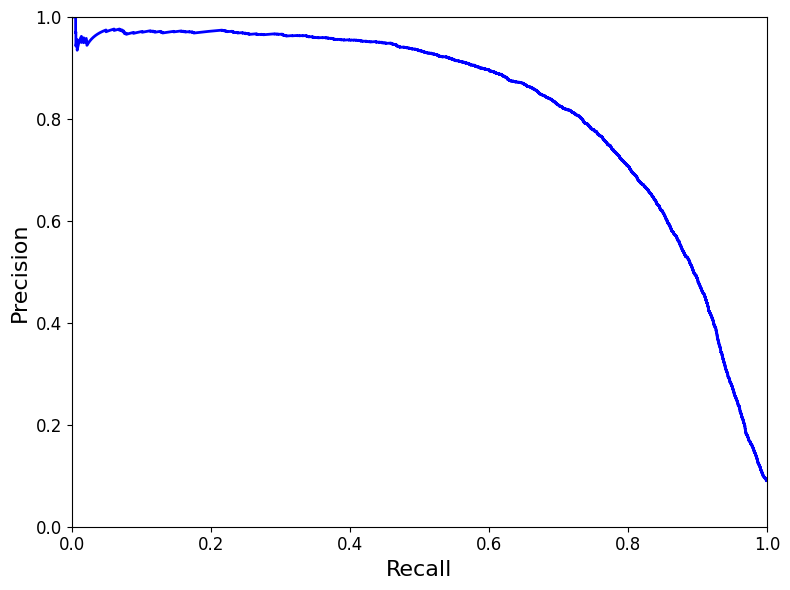

In [64]:
# below we can see it starts to fall sharply around 80%
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [67]:
# to determine percision threshold
# if I needed 90% precision I can determine the lowest threshold nthat gives me at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [68]:
# to make predictions on the training set for now
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [69]:
# check these predictions' precision and recall
# the precision classifier is 90%
precision_score(y_train_5, y_train_pred_90)

0.9001128668171557

In [71]:
recall_score(y_train_5, y_train_pred_90)

0.5884523150710201

In [72]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


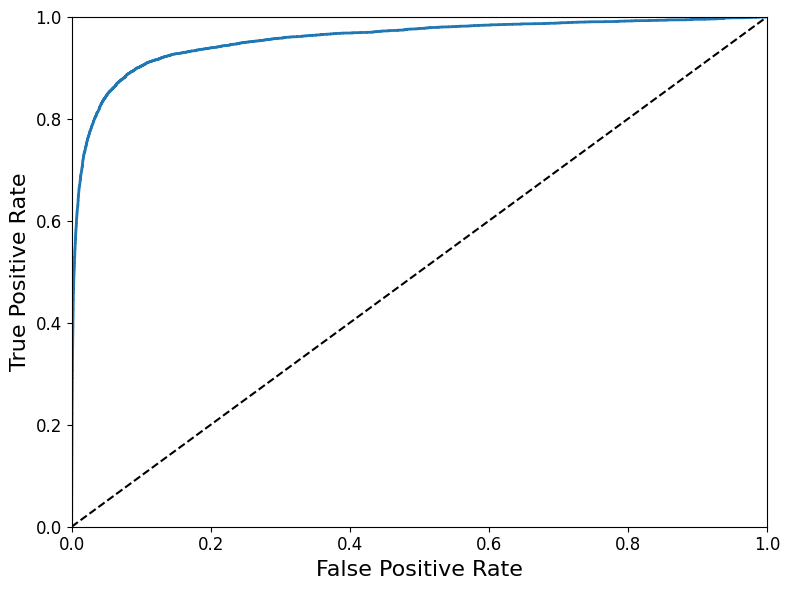

In [73]:
# plot the FPR against the TPR using Matplotlib:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()